In [14]:
import os
import json
import time
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import pickle

import seaborn
from sklearn import metrics
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

# nlp = spacy.load("fr_dep_news_trf")
# Functions : preprocess() (create dataloaders from raw data) 
# load_models() (load tokenizers and models) training() (loop of one training step) evaluate()

In [15]:
# PATH = 'text_dataset.csv'
# fields = ['label', 'article']
# df = pd.read_csv(PATH, usecols=fields)

In [16]:
# df.dropna(subset=['article'], inplace=True)
# 1 = true
# 2 = biased
# 3 = fake

In [17]:
#df['label'] = df['label'].replace([1], 0) # true label is now 0
#df['label'] = df['label'].replace([2, 3], 1) # fake and biased label are now 1

In [18]:
# dataset = df
labels = np.array(pickle.load(open("labels.p", "rb")), dtype=object)
docs = np.array(pickle.load(open("docs.p", "rb")), dtype=object)

dataset = np.vstack((labels, docs)).T

np.random.shuffle(dataset)

print(f'Dataset: {dataset.shape}')

labels = np.array(dataset[:, 0], dtype=int) - 1
docs = dataset[:, 1]

TOKENIZER = CamembertTokenizer.from_pretrained(
    'camembert-base',
    do_lower_case=True)

In [19]:
def preprocess_spacy(docs, pos=["PUNCT", "ADV", "ADJ", "VERB", "NOUN"]):
    texts = [" ".join([token.text for token in doc if not token.is_stop and token.pos_ in pos]) for doc in docs]

    return texts

def preprocess(raw_articles, labels=None):
    """
        Create pytorch dataloader from raw data
    """

    # https://huggingface.co/docs/transformers/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.batch_encode_plus.truncation

    encoded_batch = TOKENIZER.batch_encode_plus(raw_articles,
                                                add_special_tokens=False,
                                                padding = True,
                                                truncation = True,
                                                max_length = 512,
                                                return_attention_mask=True,
                                                return_tensors = 'pt')
        

    if labels is not None:
        labels = torch.tensor(labels)
        return encoded_batch['input_ids'], encoded_batch['attention_mask'], labels
    return encoded_batch['input_ids'], encoded_batch['attention_mask']
##

articles = preprocess_spacy(docs)
print(TOKENIZER.convert_ids_to_tokens(preprocess(articles, labels=labels)[0][0]))

C:\Users\louis\miniconda3\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


KeyboardInterrupt: 

In [23]:
# Split train-validation
split_border = int(len(labels)*0.8)
articles_train, articles_validation = articles[:split_border], articles[split_border:]
labels_train, labels_validation = labels[:split_border], labels[split_border:]

In [24]:
input_ids, attention_mask, labels_train = preprocess(articles_train, labels_train)
# Combine the training inputs into a TensorDataset
train_dataset = TensorDataset(
    input_ids,
    attention_mask,
    labels_train)
    

input_ids, attention_mask, labels_validation = preprocess(articles_validation, labels_validation)
# Combine the validation inputs into a TensorDataset
validation_dataset = TensorDataset(
    input_ids,
    attention_mask,
    labels_validation)


In [25]:
batch_size = 32

# Create the DataLoaders
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size)

In [26]:
model = CamembertForSequenceClassification.from_pretrained(
        'camembert-base',
        num_labels = 3)

# model.resize_token_embeddings(512)
# https://huggingface.co/transformers/v3.3.1/training.html
# https://towardsdatascience.com/visualize-bert-sequence-embeddings-an-unseen-way-1d6a351e4568

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias

In [39]:
print(model.__dict__.keys())

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_pre_hooks', '_state_dict_hooks', '_load_state_dict_pre_hooks', '_modules', 'config', 'name_or_path', 'num_labels'])


In [40]:
def predict(articles, model=model):
    with torch.no_grad():
        model.eval()
        input_ids, attention_mask = preprocess(articles)
        output = model(input_ids, attention_mask=attention_mask)
        print(output[0])
        return torch.argmax(output[0], dim=1)
predict(articles_train[:10])

# Problem with the size of the embedding layer ???

tensor([[-9.4372e-03,  4.0018e-02, -5.7815e-02],
        [-8.5199e-03,  4.8621e-02, -5.3376e-02],
        [-8.0530e-05,  5.7522e-02, -5.8356e-02],
        [ 2.5996e-03,  3.0152e-02, -4.9544e-02],
        [ 2.2937e-03,  6.5604e-02, -4.7184e-02],
        [-3.5685e-03,  6.4960e-02, -5.1989e-02],
        [-1.0069e-02,  3.3563e-02, -4.1763e-02],
        [ 1.4164e-02,  5.3247e-02, -4.4251e-02],
        [-7.7006e-03,  5.0595e-02, -5.9202e-02],
        [-1.5629e-03,  5.2786e-02, -4.2742e-02]])


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
def evaluate(articles, labels, metric='report'):
    predictions = predict(articles)
    if metric == 'report':
        return metrics.classification_report(labels, predictions, zero_division=0)
    elif metric == 'matrix':
        return metrics.confusion_matrix(labels, predictions)

In [14]:
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [15]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning Rate - Default is 5e-5
                  eps = 1e-8 # Adam Epsilon  - Default is 1e-8.
                )

In [16]:
SAVE_PATH = "first_camembert_model.model"

# Training loop
training_stats = []
                                                                                
# Measure the total training time for the whole run.
total_t0 = time.time()

epochs = 20

# Total number of training steps is [number of batches] x [number of epochs]
# (Note that this is not the same as the number of training samples)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

device = torch.device("cpu")

# This variable will evaluate the convergence on the training
consecutive_epochs_with_no_improve = 0

# Training
for epoch in range(0, epochs):
    
    print("")
    print(f'########## Epoch {epoch} / {epochs} ##########')
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    print('test time')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()
    print('model.train')

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        print(f'step : {step}')

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = time.time() - t0
            
            # Report progress
            print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {format_time(elapsed)}.')

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
        #
        # 'batch' contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: skills 
        input_id = batch[0].to(device)
        attention_mask = batch[1].to(device)
        label = batch[2].to(device)

        # Clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch)
        # the loss (because we provided skills) and the "logits"--the model
        # outputs prior to activation
        loss, logits = model(input_id, 
                             token_type_ids=None, 
                             attention_mask=attention_mask, 
                             labels=label)[:2]


        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. 'loss' is a Tensor containing a
        # single value; the '.item()' function just returns the Python value 
        # from the tensor
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)   

    if epoch > 0:
        if min([stat['Training Loss'] for stat in training_stats]) <= avg_train_loss:
            # i.e. If there is not improvement
            consecutive_epochs_with_no_improve += 1
        else:
            # If there is improvement
            consecutive_epochs_with_no_improve = 0
            print("Model saved!")
            torch.save(model.state_dict(), SAVE_PATH)
    
    # Measure how long this epoch took
    training_time = time.time() - t0

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )
    if consecutive_epochs_with_no_improve == 2:
        print("Stop training : The loss has not changed since 2 epochs!")
        break
        
torch.save(model.state_dict(), SAVE_PATH)


########## Epoch 0 / 20 ##########
Training...
test time
model.train
stef : 0
stef : 1
stef : 2
stef : 3
stef : 4
stef : 5
stef : 6
stef : 7
stef : 8
stef : 9
stef : 10
stef : 11
stef : 12
stef : 13
stef : 14


KeyboardInterrupt: 

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        94
           1       0.00      0.00      0.00        59

    accuracy                           0.61       153
   macro avg       0.31      0.50      0.38       153
weighted avg       0.38      0.61      0.47       153



<AxesSubplot:>

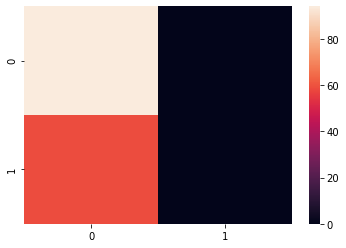

In [17]:
# Evaluation with the confusion matrix
confusion_matrix = evaluate(articles_validation, labels_validation, 'matrix')
report = evaluate(articles_validation, labels_validation, 'report')
print(report)
seaborn.heatmap(confusion_matrix)
# precision    recall  f1-score   support

#            0       0.96      0.96      0.96       482
#            1       0.98      0.99      0.99      1322

#     accuracy                           0.98      1804
#    macro avg       0.97      0.97      0.97      1804
# weighted avg       0.98      0.98      0.98      1804

In [ ]:
confusion_matrix = evaluate(articles, labels, 'matrix')
report = evaluate(articles, labels, 'report')
print(report)
seaborn.heatmap(confusion_matrix)

In [ ]:
predict(['Le réchauffement climatique est un complot des illuminatis'])